<a href="https://colab.research.google.com/github/Ashugujjar3/Airline_Crew_Scheduling_4--Ashu/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
flights_data = [
    ('F1', 9, 11),  # 9 AM to 11 AM
    ('F2', 10, 12), # 10 AM to 12 PM (Conflicts with F1)
    ('F3', 13, 15), # 1 PM to 3 PM
    ('F4', 16, 18), # 4 PM to 6 PM
    ('F5', 17, 19), # 5 PM to 7 PM (Conflicts with F4)
    ('F6', 20, 22)  # 8 PM to 10 PM
]

crew_members = ['C1', 'C2', 'C3']

MIN_REST_TIME = 1

In [3]:
## Constraint Checker

def is_valid_assignment(
    new_flight: Tuple[str, int, int],
    current_schedule: List[Tuple[str, int, int]]
) -> bool:

    new_flight_id, new_start, new_end = new_flight

    for flight_id, start, end in current_schedule:
        # Constraint 1: Check for overlaps
        # Overlap occurs if (new_start < end AND new_end > start)
        if max(new_start, start) < min(new_end, end):
            # Strict overlap, no rest possible
            return False

        # Constraint 2: Check minimum rest time (only if flights are sequential)

        # Case A: new_flight is *after* the existing flight
        # Rest time = new_start - end. Must be >= MIN_REST_TIME
        if new_start >= end:
            if new_start - end < MIN_REST_TIME:
                return False

        # Case B: new_flight is *before* the existing flight
        # Rest time = start - new_end. Must be >= MIN_REST_TIME
        elif start >= new_end:
            if start - new_end < MIN_REST_TIME:
                return False

    return True

In [4]:
## Backtracking Algorithm

def solve_crew_scheduling(
    flights: List[Tuple[str, int, int]],
    crew_members: List[str],
    index: int,
    assignment: Dict[str, List[Tuple[str, int, int]]]
) -> Dict[str, List[Tuple[str, int, int]]]:

    # Base Case: All flights have been assigned
    if index == len(flights):
        # All flights successfully assigned, return a copy of the solution
        return {
            crew: [f[0] for f in schedule]
            for crew, schedule in assignment.items()
        }

    current_flight = flights[index]

    # Try assigning the current flight to each crew member
    for crew in crew_members:
        # Check if the assignment is valid based on constraints
        current_schedule = assignment.get(crew, [])

        if is_valid_assignment(current_flight, current_schedule):

            # 1. Choose (Make the assignment)
            if crew not in assignment:
                assignment[crew] = []
            assignment[crew].append(current_flight)

            # 2. Recurse (Try to assign the next flight)
            result = solve_crew_scheduling(
                flights,
                crew_members,
                index + 1,
                assignment
            )

            # 3. Backtrack (If the recursion led to a solution, stop and return it)
            if result is not None:
                return result

            # 4. Un-Choose (If the recursion failed, undo the assignment and try the next crew member)
            assignment[crew].pop()
            if not assignment[crew]:
                del assignment[crew]

    # If all options for the current flight failed, return None
    return None

# Initial call to the solver
start_time = time.time()
final_assignment = solve_crew_scheduling(flights_data, crew_members, 0, {})
end_time = time.time()

# Extract only the flight IDs for the required output format
if final_assignment:
    print(f" Solution Found in {end_time - start_time:.4f} seconds.")
    print("\n## 4. Output: Final Crew Schedule")
    # Output Example [cite: 45]
    print(final_assignment)
else:
    print(f" No valid assignment found in {end_time - start_time:.4f} seconds.")

 Solution Found in 0.0001 seconds.

## 4. Output: Final Crew Schedule
{'C1': ['F1', 'F3', 'F4', 'F6'], 'C2': ['F2', 'F5']}


Flights: 4, Time: 0.000014 seconds
Flights: 6, Time: 0.000019 seconds
Flights: 8, Time: 0.000016 seconds
Flights: 10, Time: 0.000021 seconds
Flights: 12, Time: 0.000028 seconds


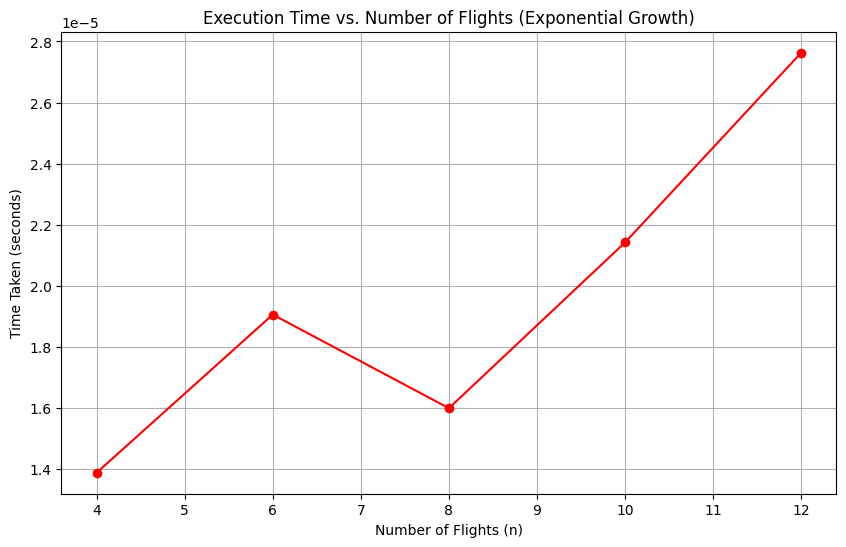

In [5]:
## 5. Analysis and Profiling

def generate_flights(n: int) -> List[Tuple[str, int, int]]:
    """Generates n flights with non-conflicting times for easier assignment."""
    flights = []
    start_time = 9
    for i in range(n):
        flight_id = f'F{i+1}'
        # Ensure a 1-hour flight time and MIN_REST_TIME gap (1 hour)
        end_time = start_time + 1
        flights.append((flight_id, start_time, end_time))
        start_time = end_time + MIN_REST_TIME
    return flights

# Input sizes to test (small 'n' because of exponential complexity) [cite: 54]
num_flights_to_test = [4, 6, 8, 10, 12]
execution_times = []
num_crew = 3 # Fixed crew size for the experiment

# Run the experiment
for n in num_flights_to_test:
    test_flights = generate_flights(n)
    test_crew = [f'C{i+1}' for i in range(num_crew)]

    start_time_exp = time.perf_counter()
    # Call the solver, we only care about time, not the output
    solve_crew_scheduling(test_flights, test_crew, 0, {})
    end_time_exp = time.perf_counter()

    time_taken = end_time_exp - start_time_exp
    execution_times.append(time_taken)
    print(f"Flights: {n}, Time: {time_taken:.6f} seconds")

# Plot the results [cite: 59]
plt.figure(figsize=(10, 6))
plt.plot(num_flights_to_test, execution_times, marker='o', linestyle='-', color='red')
plt.title('Execution Time vs. Number of Flights (Exponential Growth)')
plt.xlabel('Number of Flights (n)')
plt.ylabel(f'Time Taken (seconds) (Log Scale)' if max(execution_times) > 1 else 'Time Taken (seconds)')
# Use a log scale on the Y-axis if times vary greatly to emphasize the growth
if max(execution_times) > 1:
    plt.yscale('log')
plt.grid(True)
plt.show()

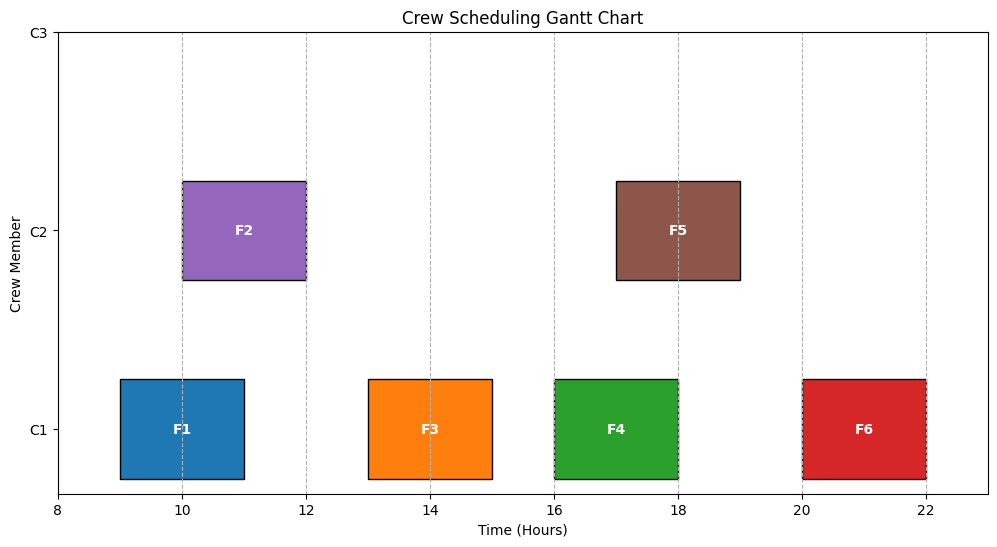

In [6]:
## 6. (Optional) Gantt Chart Visualization

if final_assignment and isinstance(final_assignment, dict):
    # To create the Gantt chart, we need the full flight details, not just IDs.
    flight_details = {f[0]: f for f in flights_data}

    # Reconstruct the assignment with full flight details for plotting
    plot_data = []
    crew_index = 0
    crew_map = {}

    for crew_member, flight_ids in final_assignment.items():
        crew_index += 1
        crew_map[crew_member] = crew_index

        for flight_id in flight_ids:
            # Look up the full (ID, Start, End) tuple
            _, start, end = flight_details.get(flight_id, (None, None, None))
            if start is not None:
                plot_data.append({
                    'Crew': crew_member,
                    'Flight': flight_id,
                    'Start': start,
                    'Duration': end - start,
                    'Crew_Idx': crew_index
                })

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(12, 6))

    # Plot bars for each flight
    for i, row in df.iterrows():
        plt.barh(
            y=row['Crew'],
            width=row['Duration'],
            left=row['Start'],
            height=0.5,
            edgecolor='black',
            label=row['Flight']
        )
        # Add flight ID label in the center of the bar
        plt.text(
            x=row['Start'] + row['Duration'] / 2,
            y=row['Crew'],
            s=row['Flight'],
            ha='center',
            va='center',
            color='white',
            fontsize=10,
            fontweight='bold'
        )

    plt.title('Crew Scheduling Gantt Chart')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Crew Member')
    plt.yticks(crew_members) # Ensure all crew members are labeled
    plt.grid(axis='x', linestyle='--')
    plt.xlim(min(df['Start']) - 1, max(df['Start'] + df['Duration']) + 1)
    plt.show()

else:
    print("Cannot generate Gantt chart: No valid assignment was found.")